### Comparing HGNN with other GNN and CNN architecture for image classfication

For thjs task, we will present three architectures and use them for MNIST classification. The 3 models encompass two graph neural networks (GNNs) and one convolutional neural network (CNN). Each utilizes a distinct approach to processing the image data, which influences their architecture and potential effectiveness for the task.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.nn import GATConv
from torch.utils.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.datasets import MNISTSuperpixels
from tqdm import tqdm
import matplotlib.pyplot as plt
import argparse
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist
from torch.optim.lr_scheduler import StepLR



In [6]:
def plot_metrics(train_losses, train_accuracies, val_accuracies):
    epochs_loss = range(1, len(train_losses) + 1)

    # Plotting training loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_loss, train_losses, label='Training Loss', marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_loss, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs_loss, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


#### Building the dataset

In [3]:
def build_mnist_superpixels_dataset(train: bool) -> MNISTSuperpixels:
    return MNISTSuperpixels(
        root="mnist-superpixels-dataset",
        train=train,
    )
    
def build_collate_fn(device: str | torch.device):
    def collate_fn(original_batch: list[Data]):
        batch_node_features: list[torch.Tensor] = []
        batch_edge_indices: list[torch.Tensor] = []
        classes: list[int] = []

        for data in original_batch:
            node_features = torch.cat((data.x, data.pos), dim=-1).to(device)
            edge_indices = data.edge_index.to(device)
            class_ = int(data.y)

            batch_node_features.append(node_features)
            batch_edge_indices.append(edge_indices)
            classes.append(class_)

        collated = {
            "batch_node_features": batch_node_features,
            "batch_edge_indices": batch_edge_indices,
            "classes": torch.LongTensor(classes).to(device),
        }

        return collated

    return collate_fn

def build_dataloader(
    dataset: MNISTSuperpixels,
    batch_size: int,
    shuffle: bool,
    device: str | torch.device,
) -> DataLoader:
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=build_collate_fn(device=device),
    )

    return loader

def build_train_val_dataloaders(batch_size: int, device: str) -> tuple[DataLoader, DataLoader]:
    train_dataset = build_mnist_superpixels_dataset(train=True)
    val_dataset = build_mnist_superpixels_dataset(train=False)

    train_loader = build_dataloader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        device=device,
    )

    val_loader = build_dataloader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        device=device,
    )

    return train_loader, val_loader

#### Models' Architecture

### 1. GNNImageClassificator

This model is based on the paper "A Graph Neural Network for Superpixel Image Classification" and employs Graph Attention Networks (GATs). The architecture is designed to work with images transformed into graph representations, where pixels or superpixels are treated as nodes, and edges are defined by spatial or other relationships.

**Architecture Overview:**
- **GAT Layers:** It uses three GATConv layers to process node features (pixels). The first layer receives initial node features, the second processes features from the first, and the third combines original and second-layer features.
- **Concatenation and Classification:** After each GAT layer, features are concatenated and eventually passed through a fully connected layer to produce the final class scores.

This approach is advantageous for capturing complex relationships between pixels and allows for a flexible integration of node features.

In [4]:
class GNNImageClassificator(nn.Module):
    """
    Source: https://github.com/Anton-Cherepkov/gnn-mnist-classification/blob/master/gnn_image_classification/model.py
    """
    def __init__(
        self,
        in_channels: int = 3,
        hidden_dim: int = 152,
        num_classes: int = 10,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.conv1 = GATConv(in_channels=in_channels, out_channels=hidden_dim)
        self.conv2 = GATConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = GATConv(in_channels=in_channels + hidden_dim, out_channels=hidden_dim)

        self.fc = nn.Sequential(
            nn.Linear(in_channels + 3 * hidden_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 32),
            nn.ReLU(True),
            nn.Linear(32, 32),
            nn.ReLU(True),
            nn.Linear(32, num_classes),
        )

    def forward_one_base(self, node_features: torch.Tensor, edge_indices: torch.Tensor) -> torch.Tensor:
        assert node_features.ndim == 2 and node_features.shape[1] == self.in_channels
        assert edge_indices.ndim == 2 and edge_indices.shape[0] == 2

        x0 = node_features

        x1 = self.conv1(x0, edge_indices)

        x2 = self.conv2(x1, edge_indices)
        x0_x2 = torch.cat((x0, x2), dim=-1)

        x3 = self.conv3(x0_x2, edge_indices)
        x0_x1_x2_x3 = torch.cat((x0, x1, x2, x3), dim=-1)

        return x0_x1_x2_x3

    def forward(self, batch_node_features: list[torch.Tensor], batch_edge_indices: list[torch.Tensor]) -> torch.Tensor:
        assert len(batch_node_features) == len(batch_edge_indices)

        features_list = []
        for node_features, edge_indices in zip(batch_node_features, batch_edge_indices):
            features_list.append(self.forward_one_base(node_features=node_features, edge_indices=edge_indices))

        features = torch.stack(features_list, dim=0)  # BATCH_SIZE x NUM_NODES x NUM_FEATURES
        features = features.mean(dim=1)  # readout operation [BATCH_SIZE x NUM_FEATURES]

        logits = self.fc(features)
        return logits

#### Train and evaluate loops

In [5]:
import torch
from tqdm import tqdm

def train_one_epoch(model, optimizer, train_loader, criterion, batches_passed):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    for batch in tqdm(train_loader, desc=f'Training for epoch {batches_passed+1}'):
        batch_node_features = batch["batch_node_features"]
        batch_edge_indices = batch["batch_edge_indices"]
        classes = batch["classes"]

        logits = model(batch_node_features=batch_node_features, batch_edge_indices=batch_edge_indices)
        predicted_classes = torch.argmax(logits, dim=1)

        loss = criterion(logits, classes).mean()
        total_loss += loss.item()
        accuracy = (predicted_classes == classes).to(torch.float32).mean()
        total_accuracy += accuracy.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_batches += 1

    average_loss = total_loss / num_batches
    average_accuracy = total_accuracy / num_batches

    return batches_passed, average_loss, average_accuracy

In [6]:
@torch.no_grad()
def evaluate(model, val_loader, epochs_passed):
    model.eval()
    accuracy_sum = 0.0
    num_samples = 0

    for batch in tqdm(val_loader, desc=f'Validation for epoch {epochs_passed + 1}'):
        batch_node_features = batch["batch_node_features"]
        batch_edge_indices = batch["batch_edge_indices"]
        classes = batch["classes"]

        logits = model(batch_node_features=batch_node_features, batch_edge_indices=batch_edge_indices)
        predicted_classes = torch.argmax(logits, dim=1)

        accuracy_sum += float((predicted_classes == classes).to(torch.float32).mean().cpu().numpy()) * len(classes)
        num_samples += len(classes)

    accuracy = accuracy_sum / num_samples
    return accuracy


In [7]:
def train(batch_size=32, epochs=10, device="cuda", hidden_dim=152, lr=0.001):
    model = GNNImageClassificator(in_channels=3, hidden_dim=hidden_dim).to(device)
    train_loader, val_loader = build_train_val_dataloaders(batch_size=batch_size, device=device)
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    batches_passed = 0
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch_ix in range(epochs):
        batches_passed, train_loss, train_accuracy = train_one_epoch(
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            criterion=torch.nn.CrossEntropyLoss(),
            batches_passed=batches_passed,
        )
        val_accuracy = evaluate(
            model=model,
            val_loader=val_loader,
            epochs_passed=epoch_ix + 1,
        )

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch_ix + 1}: Train Loss = {train_loss}, Train Accuracy = {train_accuracy}, Validation Accuracy = {val_accuracy}")

    return train_losses, train_accuracies, val_accuracies

In [8]:
train_losses, train_accuracies, val_accuracies = train(batch_size=512, epochs=10, device="cuda", hidden_dim=152, lr=0.001)

Validation for epoch 2: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


Epoch 1: Train Loss = 2.3030809386301847, Train Accuracy = 0.10902189267641407, Validation Accuracy = 0.11350000001192093


Validation for epoch 3: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


Epoch 2: Train Loss = 2.261193721981372, Train Accuracy = 0.14489539194915255, Validation Accuracy = 0.208200000166893


Validation for epoch 4: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


Epoch 3: Train Loss = 1.9986719812377025, Train Accuracy = 0.2435833776401261, Validation Accuracy = 0.27219999976158143


Validation for epoch 5: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


Epoch 4: Train Loss = 1.8143098768541368, Train Accuracy = 0.3219842425847458, Validation Accuracy = 0.34519999976158144


Validation for epoch 6: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


Epoch 5: Train Loss = 1.6949565804610818, Train Accuracy = 0.3665530103243003, Validation Accuracy = 0.4097000001907349


Validation for epoch 7: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


Epoch 6: Train Loss = 1.5699091018256495, Train Accuracy = 0.4305206128096176, Validation Accuracy = 0.44640000014305115


Validation for epoch 8: 100%|██████████| 20/20 [00:36<00:00,  1.80s/it]


Epoch 7: Train Loss = 1.4492694846654341, Train Accuracy = 0.4818480757333465, Validation Accuracy = 0.4282000000953674


Validation for epoch 9: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


Epoch 8: Train Loss = 1.396871235411046, Train Accuracy = 0.4998786194344698, Validation Accuracy = 0.5133999998092651


Validation for epoch 10: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


Epoch 9: Train Loss = 1.3573114134497561, Train Accuracy = 0.512287032301143, Validation Accuracy = 0.5161


Validation for epoch 11: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


Epoch 10: Train Loss = 1.334350968821574, Train Accuracy = 0.5228305969197872, Validation Accuracy = 0.5308999995231628


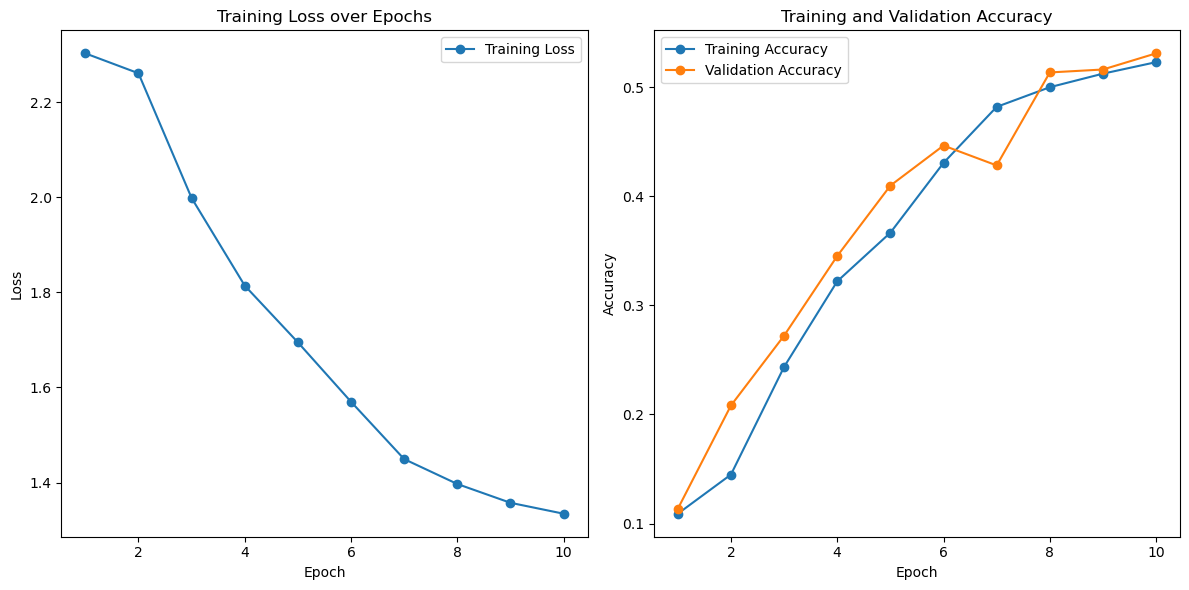

In [9]:
plot_metrics(train_losses, train_accuracies, val_accuracies)

### 2. GraphNet

Featured in Boris Knyazev's tutorial on GNNs, this model can optionally learn its adjacency matrix, which defines the connections between pixels based on their positions and potential relationships.

**Architecture Overview:**
- **Edge Prediction:** If `pred_edge` is True, it predicts the adjacency matrix based on pixel positions, allowing the model to dynamically learn how pixels should interact rather than relying on a fixed graph structure.
- **Adjacency Matrix Application:** Uses the adjacency matrix to compute the average neighbor features across the graph structure, effectively allowing each pixel to interact with its neighbors.
- **Classifier:** A single linear layer is used to classify images based on the averaged features.

This model is particularly interesting for exploring how pixel relationships can be learned rather than pre-defined, potentially adapting better to different kinds of image data.

In [22]:
# Source: https://medium.com/@BorisAKnyazev/tutorial-on-graph-neural-networks-for-computer-vision-and-beyond-part-1-3d9fada3b80d
class GraphNet(nn.Module):
    def __init__(self, image_size = 28, pred_edge = False):
        super(GraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = image_size ** 2 # Number of pixels in the image
        self.fc = nn.Linear(N, 10, bias = False)
        # Create the adjacency matrix of size (N X N)
        if pred_edge:
            # Learn the adjacency matrix (learn to predict the edge between any pair of pixels)
            col, row = np.meshgrid(np.arange(image_size), np.arange(image_size)) # (28 x 28) Explanation: https://www.geeksforgeeks.org/numpy-meshgrid-function/
            coord = np.stack((col, row), axis = 2).reshape(-1, 2)  # (784 x 2)
            coord_normalized = (coord - np.mean(coord, axis = 0)) / (np.std(coord, axis = 0) + 1e-5) # Normalize the matrix
            coord_normalized = torch.from_numpy(coord_normalized).float() # (784 x 2)
            adjacency_matrix = torch.cat((coord_normalized.unsqueeze(0).repeat(N, 1,  1),
                                    coord_normalized.unsqueeze(1).repeat(1, N, 1)), dim=2) # (784 x 784 x 4)
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(), 
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('adjacency_matrix', adjacency_matrix) # not to be considered a model paramater that is updated during training
        else:
            # Use a pre-computed adjacency matrix
            A = self.precompute_adjacency_images(image_size)
            self.register_buffer('A', A) # not to be considered a model paramater that is updated during training

    def forward(self, x):
        '''
        x: image (batch_size x 1 x image_width x image_height)
        '''
        B = x.size(0) # 64
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.adjacency_matrix).squeeze() # (784 x 784) --> predicted edge map

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1), 
                                            x.view(B, -1, 1)).view(B, -1)) # (64 X 784)
        return self.fc(avg_neighbor_features)

    @staticmethod
    # Static method knows nothing about the class and just deals with the parameters.
    def precompute_adjacency_images(image_size):
        print('precompute_adjacency_images')
        col, row = np.meshgrid(np.arange(image_size), np.arange(image_size)) # (28 x 28) Explanation: https://www.geeksforgeeks.org/numpy-meshgrid-function/
        coord = np.stack((col, row), axis = 2).reshape(-1, 2) / image_size # (784 x 2) --> normalize
        dist = cdist(coord, coord) # compute distance between every pair of pixels
        sigma = 0.05 * np.pi # width of the Gaussian (can be a hyperparameter while training a model)
        A = np.exp(-dist / sigma ** 2) # adjacency matrix of spatial similarity
        A[A < 0.01] = 0 # suppress values less than 0.01
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat

In [29]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_loss += loss.item() * data.size(0)  # Total loss for average later
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Average loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [24]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [25]:
# Set the parameters
batch_size = 512
epochs = 10
lr = 1e-3
pred_edge = False
seed = 1

use_cuda = True

torch.manual_seed(seed)

#device = torch.device("cuda" if use_cuda else "cpu")
device = "cuda"
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [26]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=False, **kwargs)    

In [27]:
model = GraphNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

print('number of trainable parameters: %d' %
      np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))


precompute_adjacency_images
tensor([[ 0.3400, -0.0852, -0.1736, -0.1938,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0852,  0.2413, -0.0987, -0.1763, -0.1944,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1736, -0.0987,  0.2207, -0.1015, -0.1768, -0.1946,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1938, -0.1763, -0.1015,  0.2166, -0.1020, -0.1770, -0.1946,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.1944, -0.1768, -0.1020,  0.2166, -0.1020, -0.1770, -0.1946,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166, -0.1020, -0.1770,
         -0.1946,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166, -0.1020,
         -0.1770, -0.1946],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166,
         -0.1020, -0.1770],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,
          0.2166, -

In [30]:
# Usage example (within a training loop)
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)

    val_loss, val_acc = test(model, device, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}: Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}%')
    print(f'Epoch {epoch}: Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.611726
Epoch 1: Train Loss: 1.0786, Train Acc: 68.34%
Epoch 1: Validation Loss: 0.6054, Validation Acc: 83.70%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.605349
Epoch 2: Train Loss: 0.5596, Train Acc: 84.43%
Epoch 2: Validation Loss: 0.4912, Validation Acc: 86.49%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.558106
Epoch 3: Train Loss: 0.4887, Train Acc: 86.17%
Epoch 3: Validation Loss: 0.4512, Validation Acc: 86.97%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.513087
Epoch 4: Train Loss: 0.4546, Train Acc: 86.98%
Epoch 4: Validation Loss: 0.4247, Validation Acc: 87.78%
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.471195
Epoch 5: Train Loss: 0.4336, Train Acc: 87.53%
Epoch 5: Validation Loss: 0.4093, Validation Acc: 88.06%
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.460745
Epoch 6: Train Loss: 0.4190, Train Acc: 87.86%
Epoch 6: Validation Loss: 0.3958, Validation Acc: 88.57%
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.395745
Epoch 7: Train Loss: 0.4082, Train Acc: 88.12%
Epoch 7: Valid

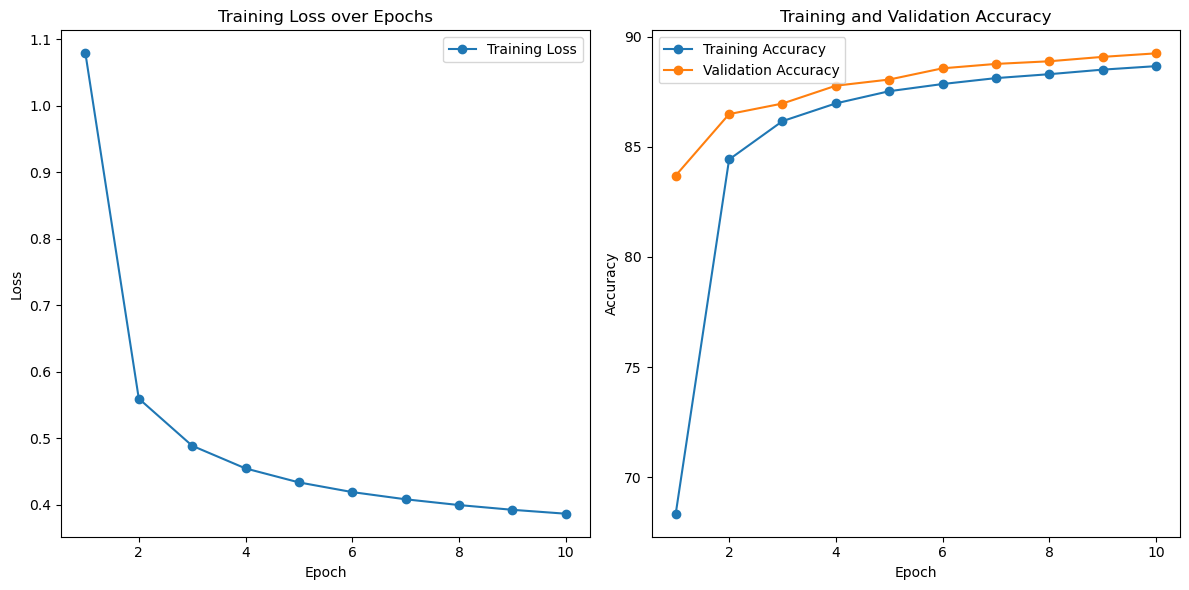

In [31]:
plot_metrics(train_losses, train_accuracies, val_accuracies)

### 3. Net (CNN)

A traditional CNN model, it utilizes convolutional layers followed by pooling and dropout for feature extraction and regularization, respectively. This is a common architecture for image classification tasks like MNIST.

**Architecture Overview:**
- **Convolutional Layers:** Two convolutional layers with ReLU activations extract spatial hierarchies of features.
- **Pooling and Dropout:** Max pooling reduces the spatial dimensions, while dropout layers help prevent overfitting.
- **Fully Connected Layers:** After flattening the features, two dense layers further process the data to produce the final output.

CNNs are well-suited for grid-like data such as images, where spatial hierarchies and local patterns (like edges and textures) are crucial for classification.

In [3]:
# Source: https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    train_accuracies = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean().item()
        train_accuracies.append(accuracy)
    
    return train_losses, train_accuracies


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [8]:
# Training settings
batch_size = 256
test_batch_size = 256
epochs = 10
lr = 1.0
gamma = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(1, epochs + 1), 'Training and evaluating the model'):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    
    train_losses.append(np.mean(train_loss))
    train_accuracies.append(np.mean(train_acc))
    val_accuracies.append(test_acc)

Training and evaluating the model: 100%|██████████| 10/10 [04:07<00:00, 24.74s/it]


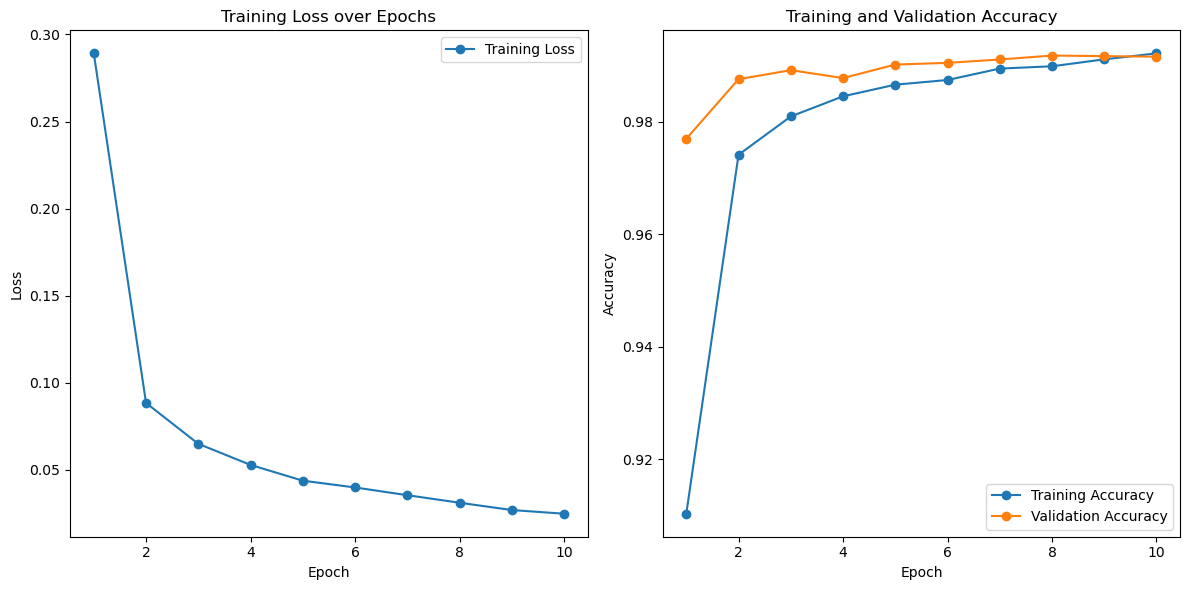

In [9]:
plot_metrics(train_losses, train_accuracies, val_accuracies)

### Differences Between the Models

- **Data Representation:** The GNNs treat images as graphs, focusing on the relationships between elements (nodes and edges), which can be especially powerful for images where contextual relationships are key. In contrast, the CNN directly processes the image as a grid, leveraging spatial relationships through convolutional filters.
- **Learning Dynamics:** GNNImageClassificator and GraphNet can adapt their processing based on the graph structure, potentially offering more flexibility in how information is integrated. The CNN, with its fixed architecture, relies on the effective but rigid convolution-pooling pattern.
- **Complexity and Interpretability:** GNNs can be more complex to implement and interpret due to their dynamic processing of relationships, while CNNs offer a more straightforward, well-understood pathway from input to classification.

### Analysis of the results
